In [1]:
import cv2
import pandas as pd
from tqdm import tqdm
import numpy as np
from pathlib import Path
# from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FOLDER_RAW_ORIG = '../data/raw/pipistrel/2018-10-07_Bodensee_chronologisch/'
FOLDER_SCALED = '../data/processed/pipistrel/scaled-200/'

### Read training labels (Bounding boxes)

In [3]:
df = pd.read_csv('../data/raw/pipistrel/labelsTrain.csv')
# df = df[df['class']=='boat']
df.head()

,filename,class,xmin,ymin,xmax,ymax,trackid
0,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,boat,2501,1537,2528,1566,1
1,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,nature,2283,2403,2318,2438,-1
2,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,nature,876,2389,917,2429,-1
3,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,nature,195,1274,235,1314,-1
4,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,nature,801,710,843,751,-1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8048 entries, 0 to 8047
Data columns (total 7 columns):
filename    8048 non-null object
class       8047 non-null object
xmin        8048 non-null int64
ymin        8048 non-null int64
xmax        8048 non-null int64
ymax        8048 non-null int64
trackid     8048 non-null int64
dtypes: int64(5), object(2)
memory usage: 440.2+ KB


Define boat/no boat class

In [5]:
df['boat'] = (df['class'] == 'boat').astype(np.int64)

In [6]:
df = df.drop(columns=['class', 'trackid'])
df.head()

,filename,xmin,ymin,xmax,ymax,boat
0,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,2501,1537,2528,1566,1
1,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,2283,2403,2318,2438,0
2,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,876,2389,917,2429,0
3,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,195,1274,235,1314,0
4,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,801,710,843,751,0


In [7]:
df.groupby('filename')['boat'].sum().sort_values(ascending=False).value_counts().sort_index()

0     349
1     203
2     128
3      72
4      46
5      12
6       4
7       3
8       1
9       1
10      1
11      1
Name: boat, dtype: int64

Number of boats per image?

In [8]:
df_nboats = df.groupby('filename')['boat'].sum().sort_values(ascending=False)
df_nboats.head()

filename
Pipstrel-Virus_Bodensee_2018-02-13_15-54-53.jpg    11
Pipstrel-Virus_Bodensee_2018-02-13_15-54-54.jpg    10
Pipstrel-Virus_Bodensee_2018-02-13_15-54-51.jpg     9
Pipstrel-Virus_Bodensee_2018-02-13_15-54-50.jpg     8
Pipstrel-Virus_Bodensee_2018-02-13_15-54-46.jpg     7
Name: boat, dtype: int64

In [9]:
df_nboats = df_nboats.rename('n_boats')

Add number of boats column:

In [10]:
df = df.join(df_nboats, on='filename')

In [11]:
df.head()

,filename,xmin,ymin,xmax,ymax,boat,n_boats
0,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,2501,1537,2528,1566,1,1
1,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,2283,2403,2318,2438,0,1
2,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,876,2389,917,2429,0,1
3,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,195,1274,235,1314,0,1
4,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,801,710,843,751,0,1


In [12]:
df.shape

(8048, 7)

In [13]:
# df.query('(boat == n_boats) | (n_boats == 0)').query('n_boats>1')
# df.query('n_boats>1')

### Separate boat and no-boat images

In [14]:
df_no_boat = df[df['n_boats']==0]
df_no_boat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3866 entries, 106 to 8047
Data columns (total 7 columns):
filename    3866 non-null object
xmin        3866 non-null int64
ymin        3866 non-null int64
xmax        3866 non-null int64
ymax        3866 non-null int64
boat        3866 non-null int64
n_boats     3866 non-null int64
dtypes: int64(6), object(1)
memory usage: 241.6+ KB


In [15]:
df_no_boat = df_no_boat.groupby('filename', as_index=False)['n_boats'].first()

In [16]:
df_no_boat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349 entries, 0 to 348
Data columns (total 2 columns):
filename    349 non-null object
n_boats     349 non-null int64
dtypes: int64(1), object(1)
memory usage: 8.2+ KB


In [17]:
df_no_boat.head()

,filename,n_boats
0,Pipstrel-Virus_Bodensee_2018-02-13_15-41-15.jpg,0
1,Pipstrel-Virus_Bodensee_2018-02-13_15-41-18.jpg,0
2,Pipstrel-Virus_Bodensee_2018-02-13_15-41-20.jpg,0
3,Pipstrel-Virus_Bodensee_2018-02-13_15-41-21.jpg,0
4,Pipstrel-Virus_Bodensee_2018-02-13_15-41-22.jpg,0


This keeps only the bounding boxes of boats (removes "nature" bboxes):

In [19]:
df_boat = df[(df['n_boats'] > 0) & (df['boat'] > 0)]
df_boat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002 entries, 0 to 8045
Data columns (total 7 columns):
filename    1002 non-null object
xmin        1002 non-null int64
ymin        1002 non-null int64
xmax        1002 non-null int64
ymax        1002 non-null int64
boat        1002 non-null int64
n_boats     1002 non-null int64
dtypes: int64(6), object(1)
memory usage: 62.6+ KB


In [20]:
df_boat.head()

,filename,xmin,ymin,xmax,ymax,boat,n_boats
0,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,2501,1537,2528,1566,1,1
10,Pipstrel-Virus_Bodensee_2018-02-13_15-41-06.jpg,2585,1351,2611,1375,1,1
22,Pipstrel-Virus_Bodensee_2018-02-13_15-41-07.jpg,2484,1163,2509,1189,1,1
34,Pipstrel-Virus_Bodensee_2018-02-13_15-41-09.jpg,2502,957,2526,984,1,1
40,Pipstrel-Virus_Bodensee_2018-02-13_15-41-10.jpg,2495,735,2518,761,1,1


### Image-handling utility functions

In [21]:
def display_image(image_name=None, parent="../data/processed/pipistrel/scaled-200/"):
    image = (Path(parent) / image_name).as_posix()
    plt.imshow(cv2.imread(image))
def get_image_shape(image_name=None, parent="../data/processed/pipistrel/scaled-200/"):
    image = (Path(parent) / image_name).as_posix()
    return cv2.imread(image).shape
def get_image_from_name(image_name=None, parent="../data/processed/pipistrel/scaled-200/"):
    image = (Path(parent) / image_name).as_posix()
    return cv2.imread(image)

Let's look at the image with 11 (!!!) boats in it:

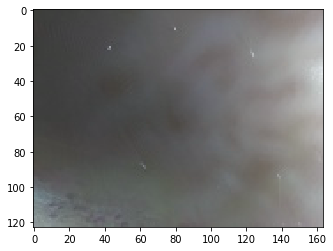

In [22]:
display_image('Pipstrel-Virus_Bodensee_2018-02-13_15-54-53.jpg')

Can't really see much, let's look at the full resolution one:

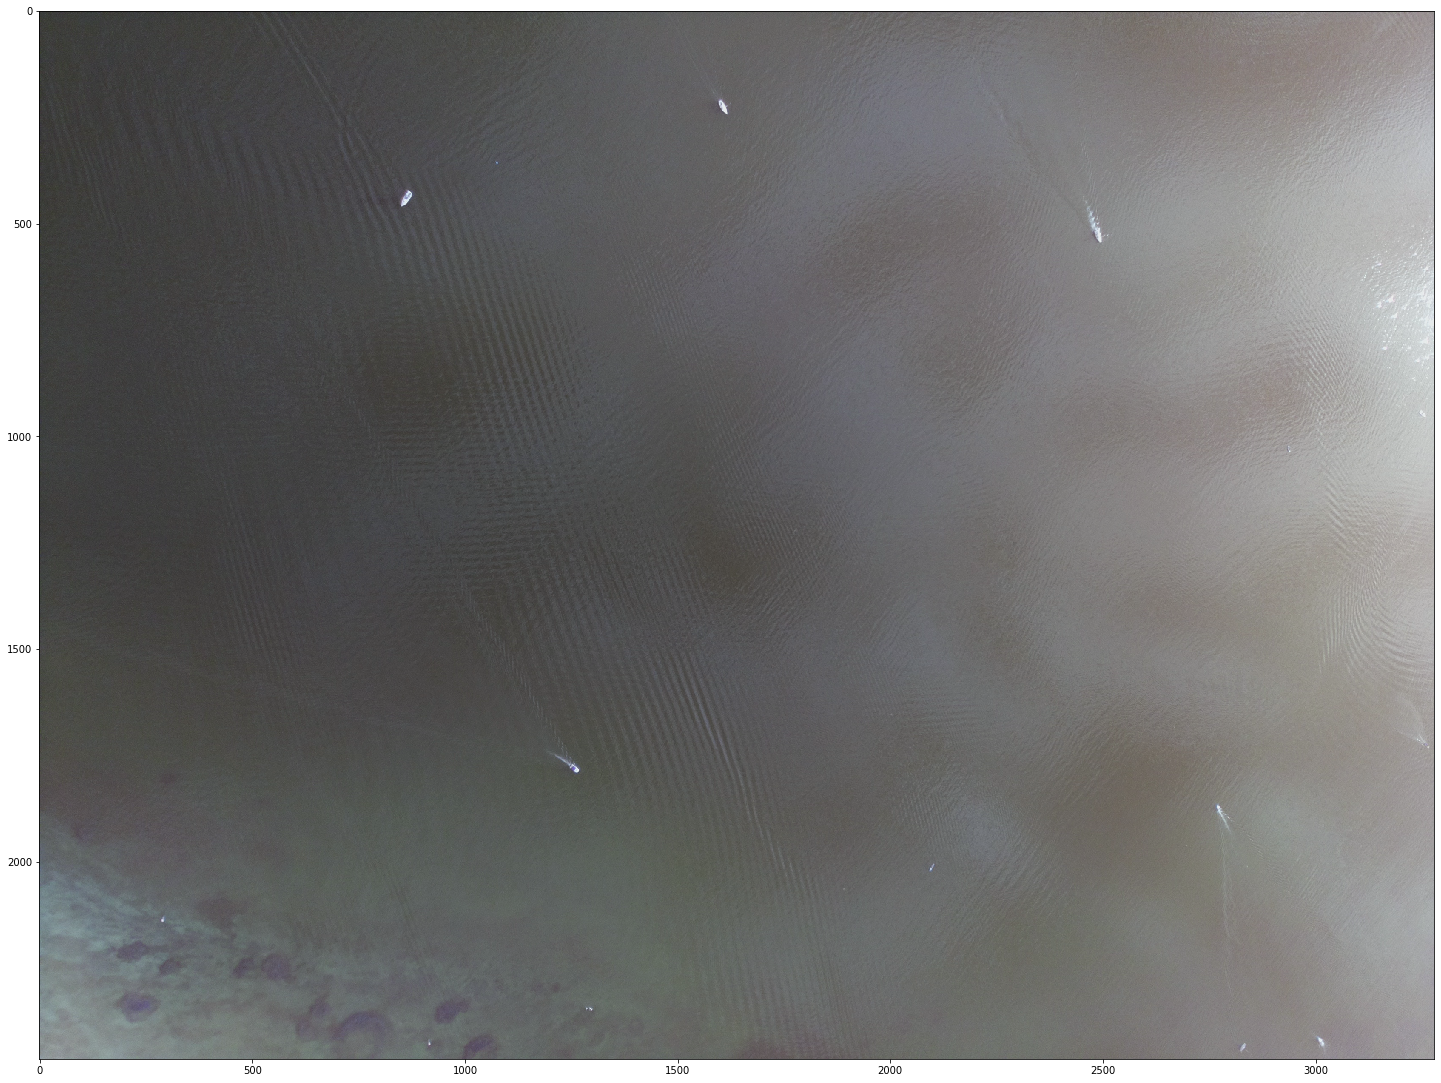

In [23]:
plt.figure(figsize=(25, 20))
display_image('Pipstrel-Virus_Bodensee_2018-02-13_15-54-53.jpg', parent=FOLDER_RAW_ORIG)

### Bounding box rescale

We need to scale the bounding boxes according to how much we rescaled the images.

In this case we use 5%.

In [24]:
SCALE_PERCENT = 5

In [25]:
df_boat.loc[
    :,
    ['xmin', 'ymin', 'xmax', 'ymax']
] = (
    df_boat.loc[:, ['xmin', 'ymin', 'xmax', 'ymax']] * SCALE_PERCENT / 100
).round(0).astype(np.int64)

/home/guzzo/anaconda3/envs/deepberlin/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
df_boat.head()

,filename,xmin,ymin,xmax,ymax,boat,n_boats
0,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,125,77,126,78,1,1
10,Pipstrel-Virus_Bodensee_2018-02-13_15-41-06.jpg,129,68,131,69,1,1
22,Pipstrel-Virus_Bodensee_2018-02-13_15-41-07.jpg,124,58,125,59,1,1
34,Pipstrel-Virus_Bodensee_2018-02-13_15-41-09.jpg,125,48,126,49,1,1
40,Pipstrel-Virus_Bodensee_2018-02-13_15-41-10.jpg,125,37,126,38,1,1


### Load images

In [27]:
from pathlib import  Path
pip_images_path = Path('../data/processed/pipistrel/scaled-200/')

In [28]:
image_paths = [x for x in pip_images_path.glob('*.jpg')]
image_paths[:10]

[PosixPath('../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_16-00-50.jpg'),
 PosixPath('../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_16-17-54.jpg'),
 PosixPath('../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_15-46-47.jpg'),
 PosixPath('../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_15-52-20.jpg'),
 PosixPath('../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_15-58-31.jpg'),
 PosixPath('../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_15-56-18.jpg'),
 PosixPath('../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_16-08-48.jpg'),
 PosixPath('../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_15-51-18.jpg'),
 PosixPath('../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_15-56-13.jpg'),
 PosixPath('../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02

In [29]:
len(image_paths)

1709

### Filter out images not in the training set

In [30]:
names = [x.name for x in image_paths]

In [31]:
train_names = set(names).intersection(set(df_boat['filename'].values))

In [32]:
mask = [x.name in train_names for x in image_paths]
mask[:10]

[True, False, True, False, False, True, False, False, True, False]

In [33]:
image_paths = np.array(image_paths)[mask].tolist()

In [34]:
len(image_paths)

472

In [35]:
import random

This is just a test:

Image ../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_15-46-58.jpg
Image ../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_15-51-01.jpg
Image ../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_15-47-26.jpg


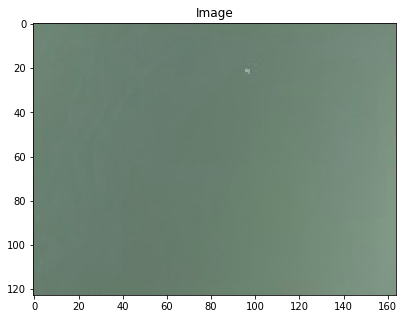

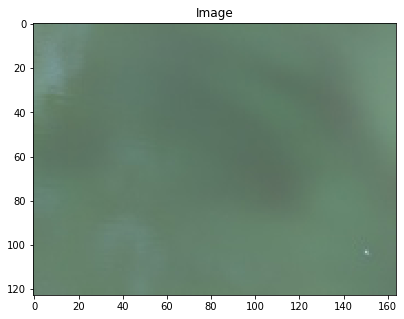

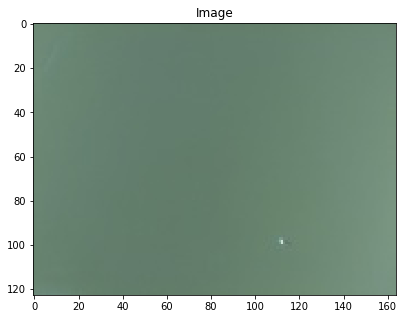

In [36]:
for i, image in enumerate(random.sample(image_paths, 3)):
    fig, ax2 = plt.subplots(1, 1, figsize = (10, 5))
    img_0 = cv2.imread(image.as_posix())
    print ('Image', image)
    ax2.set_title('Image')
    ax2.imshow(img_0)

In [37]:
# from skimage.util import montage

In [38]:
get_image_shape('Pipstrel-Virus_Bodensee_2018-02-13_15-57-36.jpg')

(123, 164, 3)

In [39]:
# plt.imshow(montage(get_image_from_name('Pipstrel-Virus_Bodensee_2018-02-13_15-57-36.jpg')))
# montage(get_image_from_name('Pipstrel-Virus_Bodensee_2018-02-13_15-57-36.jpg')[..., 0])

## Create masks from bounding boxes

In [40]:
def update_mask(mask, bbox_data):
    x1, y1, x2, y2 = bbox_data
    # Remember the image axis are inverted!!! (Y, X)
    mask[y1:y2, x1:x2] = 1
    return mask

In [41]:
%%time
mask = {}
size=get_image_shape(df_boat['filename'][0])[:2]
for name, grp in tqdm(df_boat.groupby('filename')):
#     print(i, grp)
    mask_tmp = np.zeros(size)
#     print(mask_tmp.shape)
    for row in grp.itertuples():
#         print(row)
        bbox_data = (row.xmin, row.ymin, row.xmax, row.ymax)
#         print(bbox_data)
        mask_tmp = update_mask(mask_tmp, bbox_data)
    mask[name] = mask_tmp
#     plt.figure(figsize=(20,10))
#     plt.imshow(mask_tmp)
#     print(mask_tmp.sum())


100%|██████████| 472/472 [00:00<00:00, 1710.42it/s]

CPU times: user 303 ms, sys: 7.9 ms, total: 311 ms
Wall time: 311 ms


Pipstrel-Virus_Bodensee_2018-02-13_15-42-08.jpg 3
Image ../data/processed/pipistrel/scaled-200/Pipstrel-Virus_Bodensee_2018-02-13_15-47-26.jpg


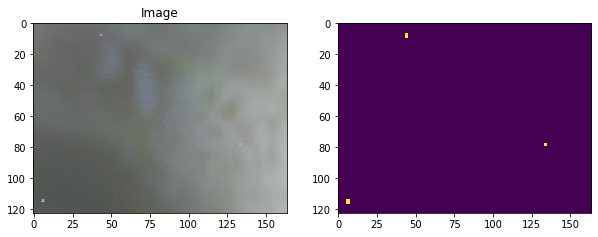

In [42]:
import random
name = random.sample(list(mask), 1)[0]
print(name, df.groupby('filename')['boat'].sum()[name])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
img_0 = cv2.imread((Path(FOLDER_SCALED) / name).as_posix())
print('Image', image)

#     ax1.scatter(data_pca[:, 0], data_pca[:, 1])
#     ax1.scatter(data_pca[i, 0], data_pca[i, 1], s=20)
#     ax1.set_title('PCA')
ax1.set_title('Image')
ax1.imshow(img_0)
ax2.imshow(mask[name])

In [43]:
len(mask)

472

In [44]:
s_mask = pd.Series(mask, name='mask')

In [45]:
s_mask.shape

(472,)

In [46]:
df_boat_mask = df_boat[['filename', 'n_boats']].groupby(
        'filename',
        as_index=False
    ).first().join(
        s_mask,
        on='filename',
        how='left'
    )

In [47]:
df_boat_mask.shape

(472, 3)

In [48]:
df_boat_mask.head()

,filename,n_boats,mask
0,Pipstrel-Virus_Bodensee_2018-02-13_15-41-05.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Pipstrel-Virus_Bodensee_2018-02-13_15-41-06.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,Pipstrel-Virus_Bodensee_2018-02-13_15-41-07.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Pipstrel-Virus_Bodensee_2018-02-13_15-41-09.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Pipstrel-Virus_Bodensee_2018-02-13_15-41-10.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


                                            filename  n_boats
412  Pipstrel-Virus_Bodensee_2018-02-13_15-54-53.jpg       11


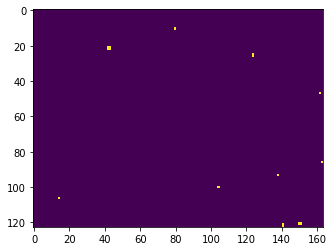

In [49]:
import random
name = 'Pipstrel-Virus_Bodensee_2018-02-13_15-54-53.jpg'
print(df_boat_mask[df_boat_mask['filename']==name][['filename', 'n_boats']])
plt.imshow(df_boat_mask.set_index('filename').loc[name, 'mask'])

### Create empty masks for no-boat images

In [50]:
size = get_image_shape(df_no_boat['filename'][0])[:2]

In [51]:
size

(123, 164)

In [52]:
df_no_boat.head()

,filename,n_boats
0,Pipstrel-Virus_Bodensee_2018-02-13_15-41-15.jpg,0
1,Pipstrel-Virus_Bodensee_2018-02-13_15-41-18.jpg,0
2,Pipstrel-Virus_Bodensee_2018-02-13_15-41-20.jpg,0
3,Pipstrel-Virus_Bodensee_2018-02-13_15-41-21.jpg,0
4,Pipstrel-Virus_Bodensee_2018-02-13_15-41-22.jpg,0


In [53]:
df_no_boat['mask'] = df_no_boat.apply(lambda x: np.zeros(size), axis=1)

In [54]:
df_no_boat.head()

,filename,n_boats,mask
0,Pipstrel-Virus_Bodensee_2018-02-13_15-41-15.jpg,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,Pipstrel-Virus_Bodensee_2018-02-13_15-41-18.jpg,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,Pipstrel-Virus_Bodensee_2018-02-13_15-41-20.jpg,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Pipstrel-Virus_Bodensee_2018-02-13_15-41-21.jpg,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,Pipstrel-Virus_Bodensee_2018-02-13_15-41-22.jpg,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


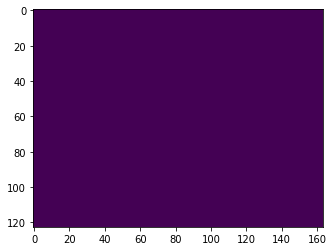

In [55]:
name = 'Pipstrel-Virus_Bodensee_2018-02-13_15-41-15.jpg'
plt.imshow(df_no_boat.set_index('filename').loc[name, 'mask'])

# Create a single data preparation function

See next notebook!